# DLVC WS 2017

Tutorial 6: CIFAR Classification (Autoencoders)
==

Load Packages
==

In [1]:
%matplotlib inline
import torch
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import copy

Load Data:
===============

In [2]:
transform = transforms.Compose([transforms.ToTensor()])
BatchSize = 100

trainset = torchvision.datasets.CIFAR10(root='./CIFAR10', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BatchSize,
                                          shuffle=True, num_workers=4) # Creating dataloader

testset = torchvision.datasets.CIFAR10(root='./CIFAR10', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BatchSize,
                                         shuffle=False, num_workers=4) # Creating dataloader

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


In [3]:
# Check availability of GPU
use_gpu = torch.cuda.is_available()
if use_gpu:
    print('GPU is available!')

Define the Autoencoder:
===============

In [4]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(3*32*32, 900),
            nn.ReLU(),
            nn.Linear(900, 256),
            nn.ReLU())
        self.decoder = nn.Sequential(
            nn.Linear(256, 900),
            nn.ReLU(),
            nn.Linear(900, 3*32*32),
            nn.ReLU())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


net = autoencoder()
print(net)

if use_gpu:
    net = net.double().cuda()
else:
    net = net.double()
        
init_weights = copy.deepcopy(net.encoder[0].weight.data)

autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=3072, out_features=900)
    (1): ReLU()
    (2): Linear(in_features=900, out_features=256)
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=256, out_features=900)
    (1): ReLU()
    (2): Linear(in_features=900, out_features=3072)
    (3): ReLU()
  )
)


Train Autoencoder:
===========

In [5]:
# functions to show an image
def imshow(img, strlabel):
    npimg = img.numpy()
    npimg = np.abs(npimg)
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 10
    fig_size[1] = 10
    plt.rcParams["figure.figsize"] = fig_size
    plt.figure()
    plt.title(strlabel)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [6]:
iterations = 100
learning_rate = 0.9
criterion = nn.MSELoss()

dataiter = iter(testloader)
images, labels = dataiter.next()
printImg = torch.Tensor(iterations/10,2,3,32,32)

for epoch in range(iterations):  # loop over the dataset multiple times
    runningLoss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        # wrap them in Variable
        if use_gpu:
            inputs = Variable(inputs.view(-1, 3*32*32).double()).cuda()
        else:
            inputs = Variable(inputs.view(-1, 3*32*32).double())

        net.zero_grad()  # zeroes the gradient buffers of all parameters
        outputs = net(inputs) # forward 
        loss = criterion(outputs, inputs) # calculate loss
        loss.backward() #  backpropagate the loss
        for f in net.parameters():
            f.data.sub_(f.grad.data * learning_rate) # weight = weight - learning_rate * gradient (Update Weights)
        runningLoss += loss.data[0]
        
    print('At Iteration : %d / %d  ;  Mean-Squared Error : %f'%(epoch + 1,iterations,
                                                                        runningLoss/(60000/BatchSize)))
    if epoch%10 == 0:
        if use_gpu:
            outImg = net(Variable((images[0].view(-1,3*32*32).double().cuda()))).data
            outImg = outImg.view(3,32,32).cpu()
        else:
            outImg = net(Variable((images[0].view(-1,3*32*32).double()))).data
            outImg = outImg.view(3,32,32).cpu()

        dispImg = torch.Tensor(2,3,32,32)
        dispImg[0] = images[0]
        dispImg[1] = outImg
        printImg[epoch/10] = dispImg
print('Finished Training')

At Iteration : 1 / 100  ;  Mean-Squared Error : 0.114716
At Iteration : 2 / 100  ;  Mean-Squared Error : 0.089599
At Iteration : 3 / 100  ;  Mean-Squared Error : 0.076404
At Iteration : 4 / 100  ;  Mean-Squared Error : 0.066288
At Iteration : 5 / 100  ;  Mean-Squared Error : 0.059306
At Iteration : 6 / 100  ;  Mean-Squared Error : 0.054404
At Iteration : 7 / 100  ;  Mean-Squared Error : 0.050808
At Iteration : 8 / 100  ;  Mean-Squared Error : 0.048178
At Iteration : 9 / 100  ;  Mean-Squared Error : 0.046375
At Iteration : 10 / 100  ;  Mean-Squared Error : 0.044735
At Iteration : 11 / 100  ;  Mean-Squared Error : 0.042916
At Iteration : 12 / 100  ;  Mean-Squared Error : 0.041275
At Iteration : 13 / 100  ;  Mean-Squared Error : 0.039709
At Iteration : 14 / 100  ;  Mean-Squared Error : 0.038736
At Iteration : 15 / 100  ;  Mean-Squared Error : 0.037573
At Iteration : 16 / 100  ;  Mean-Squared Error : 0.036517
At Iteration : 17 / 100  ;  Mean-Squared Error : 0.035681
At Iteration : 18 / 100

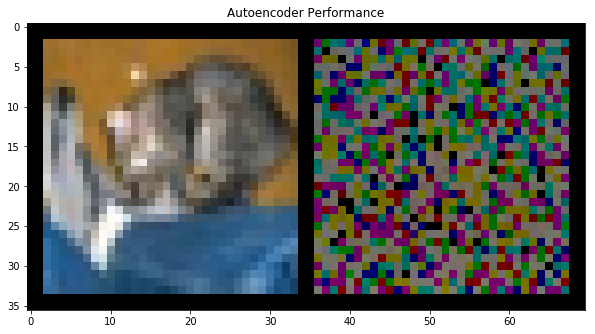

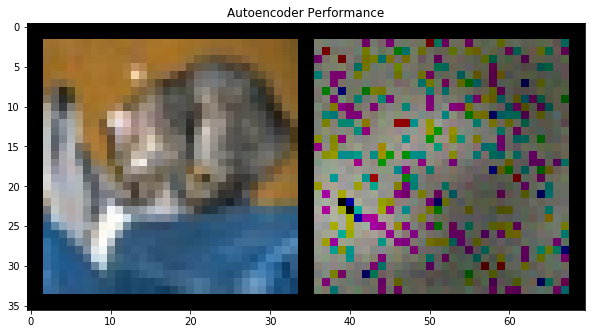

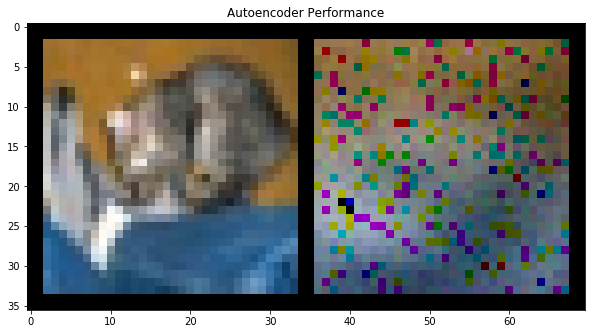

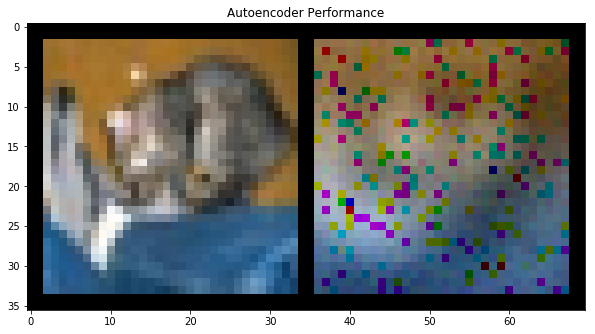

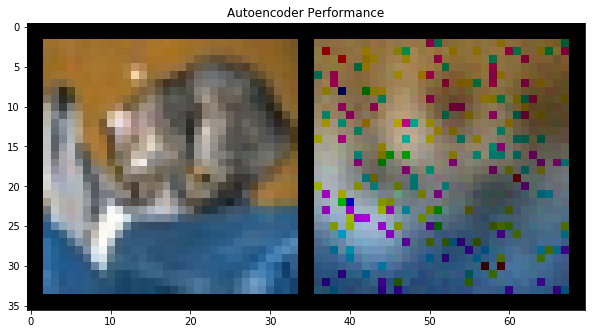

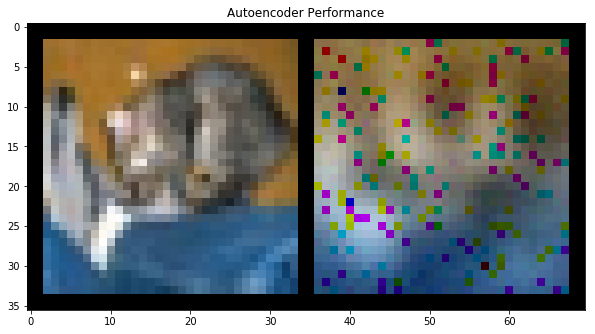

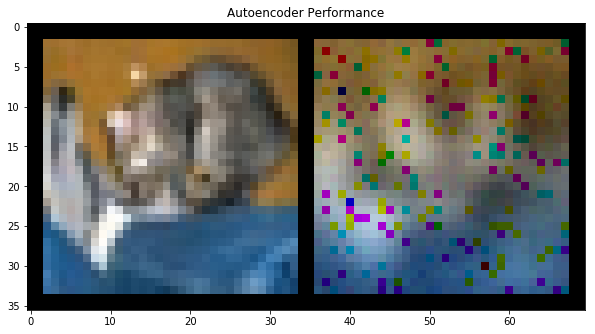

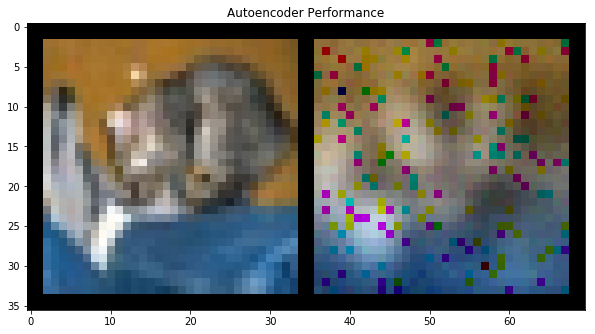

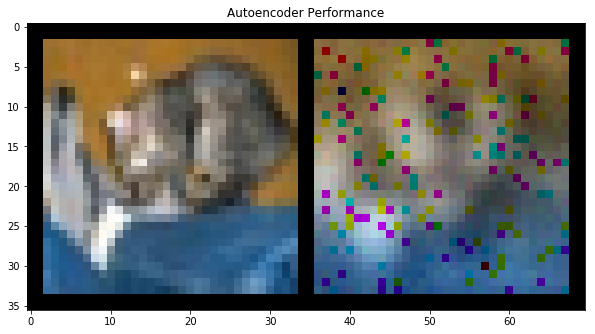

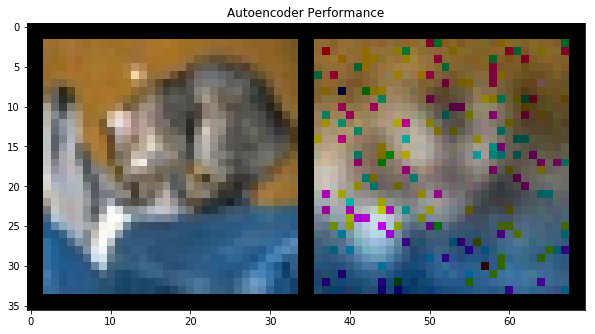

In [7]:
for i in range(iterations/10):
    imshow(torchvision.utils.make_grid(printImg[i]), 'Autoencoder Performance')

Encoder Weights Visualization:
=======================

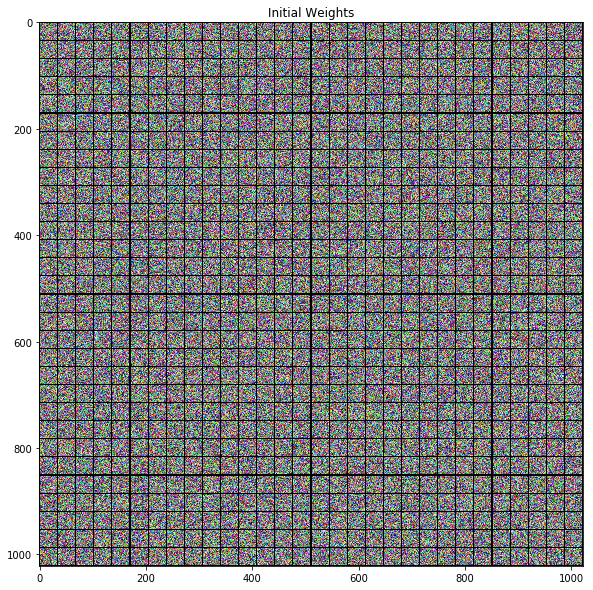

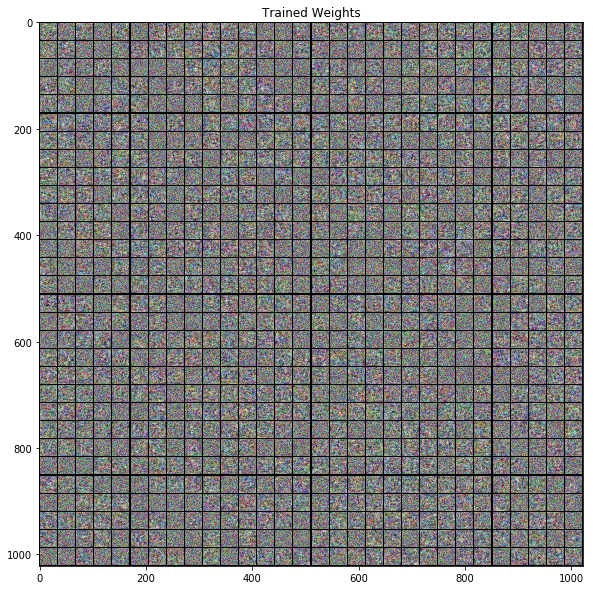

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [8]:
trained_weights = copy.deepcopy(net.encoder[0].weight.data)
d_weights = init_weights - trained_weights 

if use_gpu:
    init_weights = init_weights.view(900,3,32,32).cpu()
    trained_weights = trained_weights.view(900,3,32,32).cpu()
    d_weights = d_weights.view(900,3,32,32).cpu()
else:
    init_weights = init_weights.view(900,3,32,32)
    trained_weights = trained_weights.view(900,3,32,32)
    d_weights = d_weights.view(900,3,32,32)

imshow(torchvision.utils.make_grid(init_weights,nrow=30,normalize=True),'Initial Weights')
imshow(torchvision.utils.make_grid(trained_weights,nrow=30,normalize=True),'Trained Weights')
imshow(torchvision.utils.make_grid(d_weights,nrow=30,normalize=True), 'Weight update')

Modifying the autoencoder for classification: 
================================

In [9]:
# Removing the decoder module from the autoencoder
new_classifier = nn.Sequential(*list(net.children())[:-1])
net = new_classifier
# Adding linear layer for 10-class classification problem
net.add_module('classifier', nn.Sequential(nn.Linear(256, 10),nn.LogSoftmax()))
print(net)
if use_gpu:
    net = net.double().cuda()
else:
    net = net.double()
# Copying initial weights  for visualization
cll_weights = copy.deepcopy(net[0][0].weight.data)
init_classifier_weights = copy.deepcopy(net.classifier[0].weight.data)

Sequential(
  (0): Sequential(
    (0): Linear(in_features=3072, out_features=900)
    (1): ReLU()
    (2): Linear(in_features=900, out_features=256)
    (3): ReLU()
  )
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=10)
    (1): LogSoftmax()
  )
)


Train Classifier:
===========

In [10]:
iterations = 10
learning_rate = 0.1
criterion = nn.CrossEntropyLoss()

for epoch in range(iterations):  # loop over the dataset multiple times

    runningLoss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        
        # wrap them in Variable
        if use_gpu:
            inputs, labels = Variable(inputs.view(-1, 3*32*32).double()).cuda(), Variable(labels).cuda()
        else:
            inputs, labels = Variable(inputs.view(-1, 3*32*32).double()), Variable(labels)

        net.zero_grad()  # zeroes the gradient buffers of all parameters
        outputs = net(inputs) # forward 
        loss = criterion(outputs, labels) # calculate loss
        loss.backward() #  backpropagate the loss
        for f in net.parameters():
            f.data.sub_(f.grad.data * learning_rate) # weight = weight - learning_rate * gradient (Update Weights)
        runningLoss += loss.data[0]
        correct = 0
        total = 0
    for data in testloader:
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.view(-1, 3*32*32).double()).cuda(), labels.cuda()
        else:
            inputs, labels = Variable(inputs.view(-1, 3*32*32).double()), labels
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
    print('At Iteration : %d / %d  ;  Train Error : %f ;Test Accuracy : %f'%(epoch + 1,iterations,
                                                                        runningLoss/(60000/BatchSize),100 * correct /float(total)))
print('Finished Training')

/home/iteradmin/anaconda2/lib/python2.7/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


At Iteration : 1 / 10  ;  Train Error : 1.593857 ;Test Accuracy : 36.060000
At Iteration : 2 / 10  ;  Train Error : 1.414558 ;Test Accuracy : 44.700000
At Iteration : 3 / 10  ;  Train Error : 1.339233 ;Test Accuracy : 43.190000
At Iteration : 4 / 10  ;  Train Error : 1.285077 ;Test Accuracy : 45.440000
At Iteration : 5 / 10  ;  Train Error : 1.240720 ;Test Accuracy : 47.120000
At Iteration : 6 / 10  ;  Train Error : 1.203159 ;Test Accuracy : 48.920000
At Iteration : 7 / 10  ;  Train Error : 1.172858 ;Test Accuracy : 48.260000
At Iteration : 8 / 10  ;  Train Error : 1.139376 ;Test Accuracy : 50.150000
At Iteration : 9 / 10  ;  Train Error : 1.115876 ;Test Accuracy : 50.160000
At Iteration : 10 / 10  ;  Train Error : 1.088985 ;Test Accuracy : 51.540000
Finished Training


Encoder Weights Visualization:
=======================

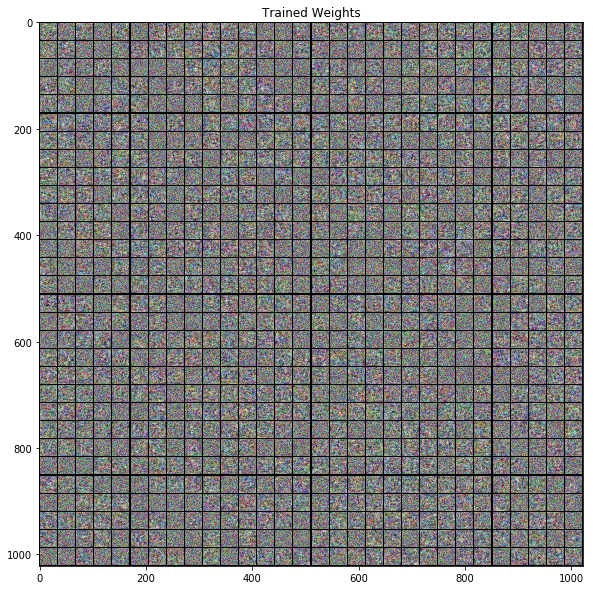

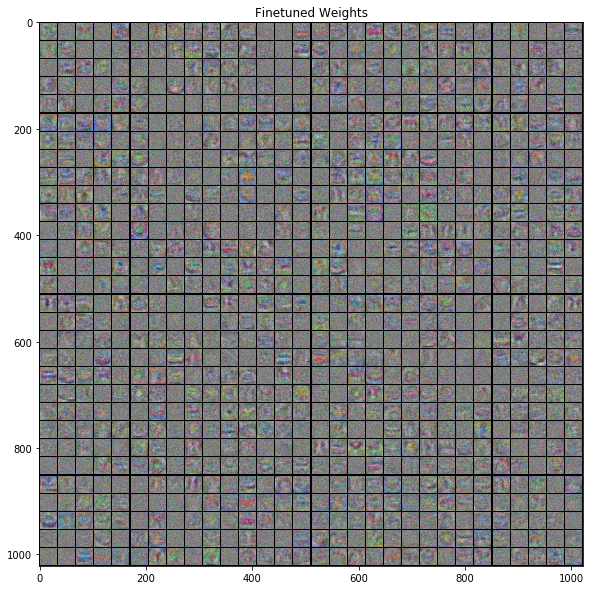

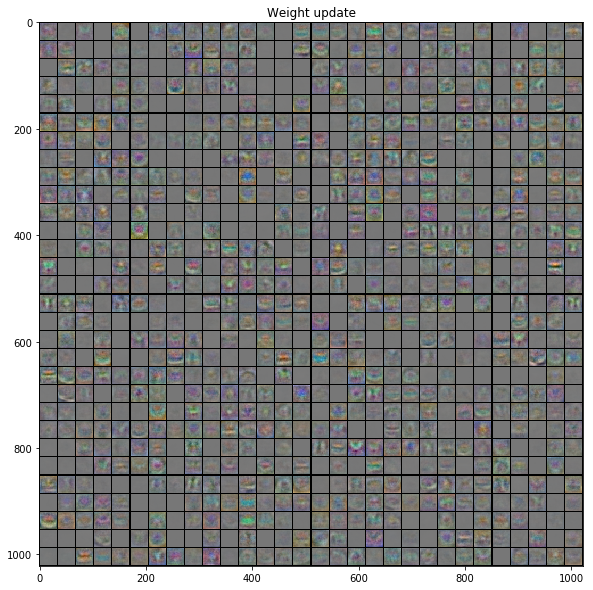

In [11]:
cll_weights_ft = copy.deepcopy(net[0][0].weight.data)
d_weights = cll_weights-cll_weights_ft 

if use_gpu:
    cll_weights = cll_weights.view(900,3,32,32).cpu()
    cll_weights_ft = cll_weights_ft.view(900,3,32,32).cpu()
    d_weights = d_weights.view(900,3,32,32).cpu()
else:
    cll_weights = cll_weights.view(900,3,32,32)
    cll_weights_ft = cll_weights_ft.view(900,3,32,32)
    d_weights = d_weights.view(900,3,32,32)

imshow(torchvision.utils.make_grid(cll_weights,nrow=30,normalize=True),'Trained Weights')
imshow(torchvision.utils.make_grid(cll_weights_ft,nrow=30,normalize=True),'Finetuned Weights')
imshow(torchvision.utils.make_grid(d_weights,nrow=30,normalize=True), 'Weight update')

Performance of different Classes:
==================

In [12]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
for data in testloader:
    images, labels = data
    if use_gpu:
        outputs = net(Variable(images.view(-1, 3*32*32).double().cuda()))
        _, predicted = torch.max(outputs.data.cpu(), 1)
    else:
        outputs = net(Variable(images.view(-1, 3*32*32).double()))
        _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels).squeeze()
    for i in range(4):
        label = labels[i]
        class_correct[label] += c[i]
        class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %f %%' % (
        classes[i], 100 * class_correct[i] / float(class_total[i])))

Accuracy of plane : 61.363636 %
Accuracy of   car : 71.875000 %
Accuracy of  bird : 23.684211 %
Accuracy of   cat : 44.186047 %
Accuracy of  deer : 55.102041 %
Accuracy of   dog : 34.375000 %
Accuracy of  frog : 35.849057 %
Accuracy of horse : 59.375000 %
Accuracy of  ship : 58.333333 %
Accuracy of truck : 68.965517 %
